# Demo 3 - Create an Animation

ROMY data of an M6.8 event in 2023 is processed and a waveform and particle motion animation created and stored.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from sixdegrees.sixdegrees import sixdegrees
from sixdegrees.plots import animate_waveforms

## Configurations

We load a pre-defined configuration file that loads the 6-DoF data from a mseed file.

In [2]:
config = sixdegrees.load_from_yaml("./config/config_ROMY_M6.8_20230908_file.yml")

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Get key information about the event

In [4]:
ev = sd.get_event_info(
    base_catalog="USGS",
    origin_time=config['origin_time'],
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


In [5]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching XX.ROMY..BHZ data from mseed file
-> fetching XX.ROMY..BHN data from mseed file
-> fetching XX.ROMY..BHE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching XX.ROMY..BJZ data from mseed file
-> fetching XX.ROMY..BJN data from mseed file
-> fetching XX.ROMY..BJE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.999400Z | 20.0 Hz, 56441 samples
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples


Ensure that all traces of stream have the same sample size

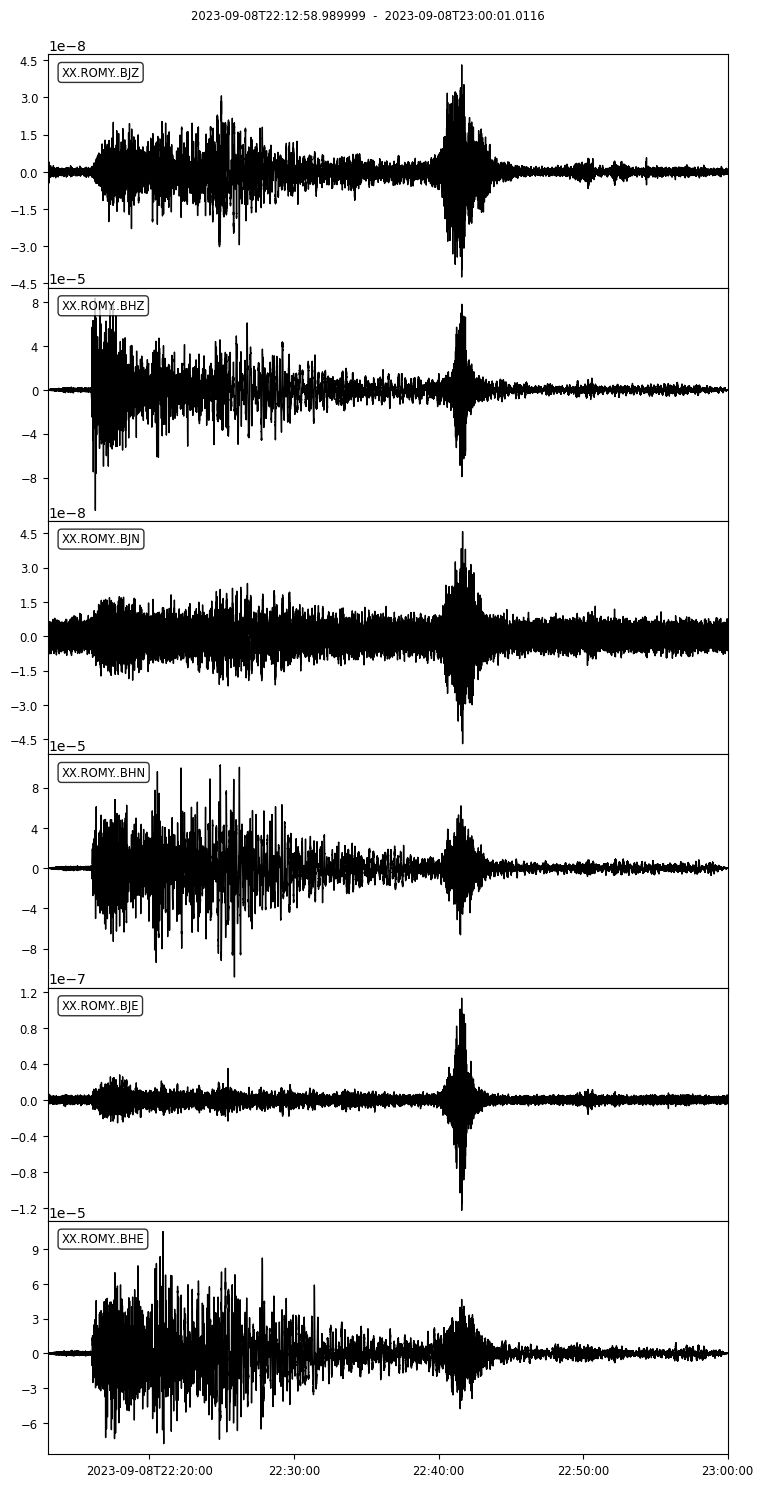

In [6]:
sd.st.plot(equal_scale=False);

## Processing

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [7]:
# trim the stream to the time window
sd.trim_stream(set_common=True, set_interpolate=False)

# filter the data
sd.filter_data(fmin=config['fmin'], fmax=config['fmax'], output=False)

# apply polarity correction
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

# trim the stream to the time window
sd.trim(UTCDateTime(config['tbeg'])+100, UTCDateTime(config['tend'])-1000)


 -> stream size inconsistent: [56441, 56441, 56441, 56441, 56441, 56440]
  -> adjusted: [56440, 56440, 56440, 56440, 56440, 56440]
-> polarity for channel HZ changed from 1 to -1


Now, let's compare the waveforms of the rotation (red) and translational (black) components 

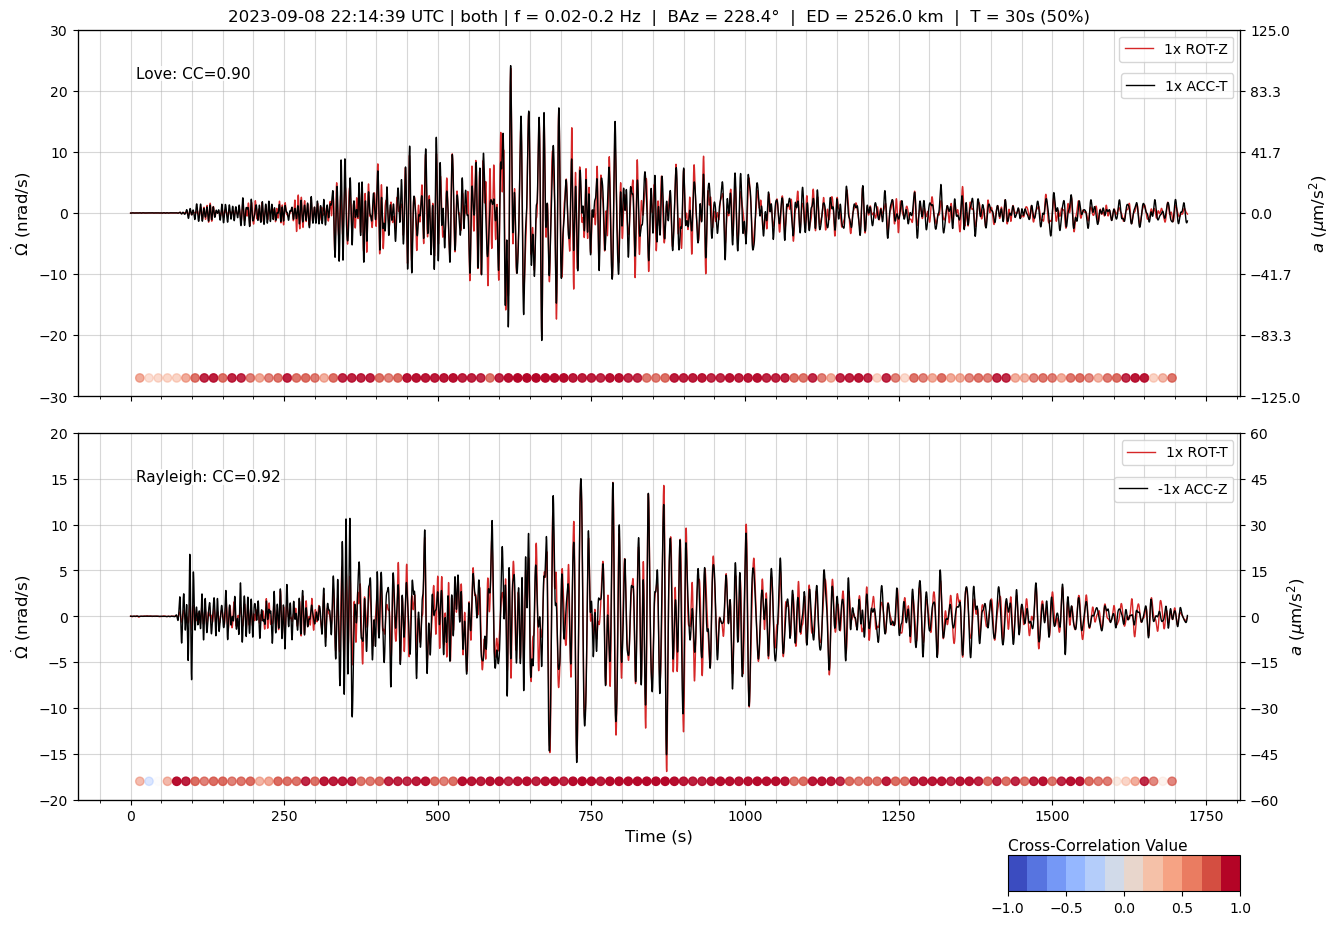

In [8]:
fig = sd.plot_waveform_cc(
    twin_sec=config['twin_sec'],
    twin_overlap=config['twin_overlap'],
    wave_type="both"
)

## Animation

Create an animated visualization of the waveforms and particle motion. This may take a few minutes depending on the duration and frame rate.


### Animate Waveforms and Particle Motion

In [ ]:
t0 = time.time()

print("This may take several minutes...\n")

# Create and save the animation
anim_saved = animate_waveforms(
    sd=sd,
    time_step=1, # time step between frames in seconds
    duration=1800, # duration of animation in seconds
    dpi=150, # DPI for saved animation
    show_arrivals=True, # Show P and S wave arrival times
    rotate_zrt=True, # Rotate to ZRT coordinates
    tail_duration=30.0, # Duration of particle motion tail
    baz=ev['backazimuth'], # Use theoretical backazimuth
    save_path=f"./output/ROMY_M6.8_20230908_animation.mp4",
)

print(f"\nTime elapsed: {time.time() - t0:.2f} seconds")
print(f"\nAnimation saved successfully to: {save_path}")
print(f"\nFile size: {os.path.getsize(save_path) / (1024*1024):.1f} MB")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3640648224.py, line 14)

### Animate with 3D Cube

In [10]:
from sixdegrees.plots import animate_waveforms_3d

t0 = time.time()

# Create 3D animation
anim = animate_waveforms_3d(
    sd=sd,
    time_step=.2, # time step between frames in seconds
    duration=1800, # duration of animation in seconds
    cube_scale=0.3,  # Adjust cube size
    show_arrivals=True, # Show P and S wave arrival times
    dpi=150, # DPI for saved animation
    rotate_zrt=True, # Rotate to ZRT coordinates
    baz=ev['backazimuth'], # Use theoretical backazimuth
    save_path="./output/ROMY_M6.8_20230908_animation_3d.mp4"
)

print(f"\nTime elapsed: {time.time() - t0:.2f} seconds")

Using backazimuth: 228.4°
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:14:40.011600Z - 2023-09-08T22:43:20.011600Z | 20.0 Hz, 34401 samples
XX.ROMY..BJR | 2023-09-08T22:14:39.999400Z - 2023-09-08T22:43:19.999400Z | 20.0 Hz, 34401 samples
XX.ROMY..BJT | 2023-09-08T22:14:39.986600Z - 2023-09-08T22:43:19.986600Z | 20.0 Hz, 34401 samples 3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:14:39.989999Z - 2023-09-08T22:43:19.989999Z | 20.0 Hz, 34401 samples
XX.ROMY..BHR | 2023-09-08T22:14:39.990000Z - 2023-09-08T22:43:19.990000Z | 20.0 Hz, 34401 samples
XX.ROMY..BJT | 2023-09-08T22:14:39.986600Z - 2023-09-08T22:43:19.986600Z | 20.0 Hz, 34401 samples
Animation parameters:
Duration: 1720.00s
Time step: 0.200s
Number of frames: 8600
Frame rate: 5.0 fps
Integrating translational data (acceleration to displacement)...
Integrating rotational data (rotation rate to rotation angle)...
Normalizing traces to [-1, 1] range...
Theoretical P-arrival: 2023-09-08T22:16:02.016641Z
Theoretical S-arriva